In [1]:
#impoting libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

### Import the data

In [2]:
#Load the Data
train = pd.read_csv('train.csv')
features = [c for c in train.columns if c not in ['ID_code', 'target']]

### Data Exploration

In [3]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [5]:
train.shape

(200000, 202)

In [6]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


### Check for missing and null values

In [7]:
train.isna().sum().sort_values(ascending = False)

var_199    0
var_61     0
var_71     0
var_70     0
var_69     0
          ..
var_129    0
var_128    0
var_127    0
var_126    0
ID_code    0
Length: 202, dtype: int64

There are no missing values in the dataset.
The data obtained is entirely masked so with even domain knowledge we will not be able to find out any significant features. We can try with basic features like mean, standard deviation, counts, median, etc. We will do feature engineering later.

# Visualizing data
#Target Distribution

<AxesSubplot:xlabel='target', ylabel='count'>

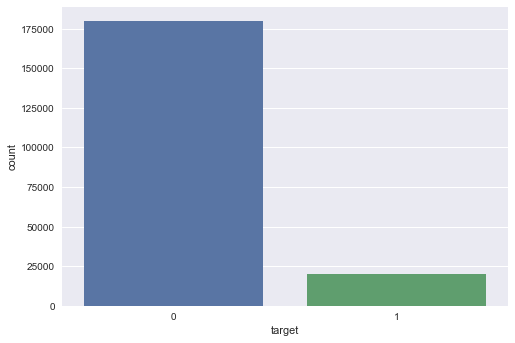

In [8]:
sns.countplot(train['target'])

In [9]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [10]:
t0=train[train['target']==0]
t1=train[train['target']==1]

Distributions of 1st 100 features


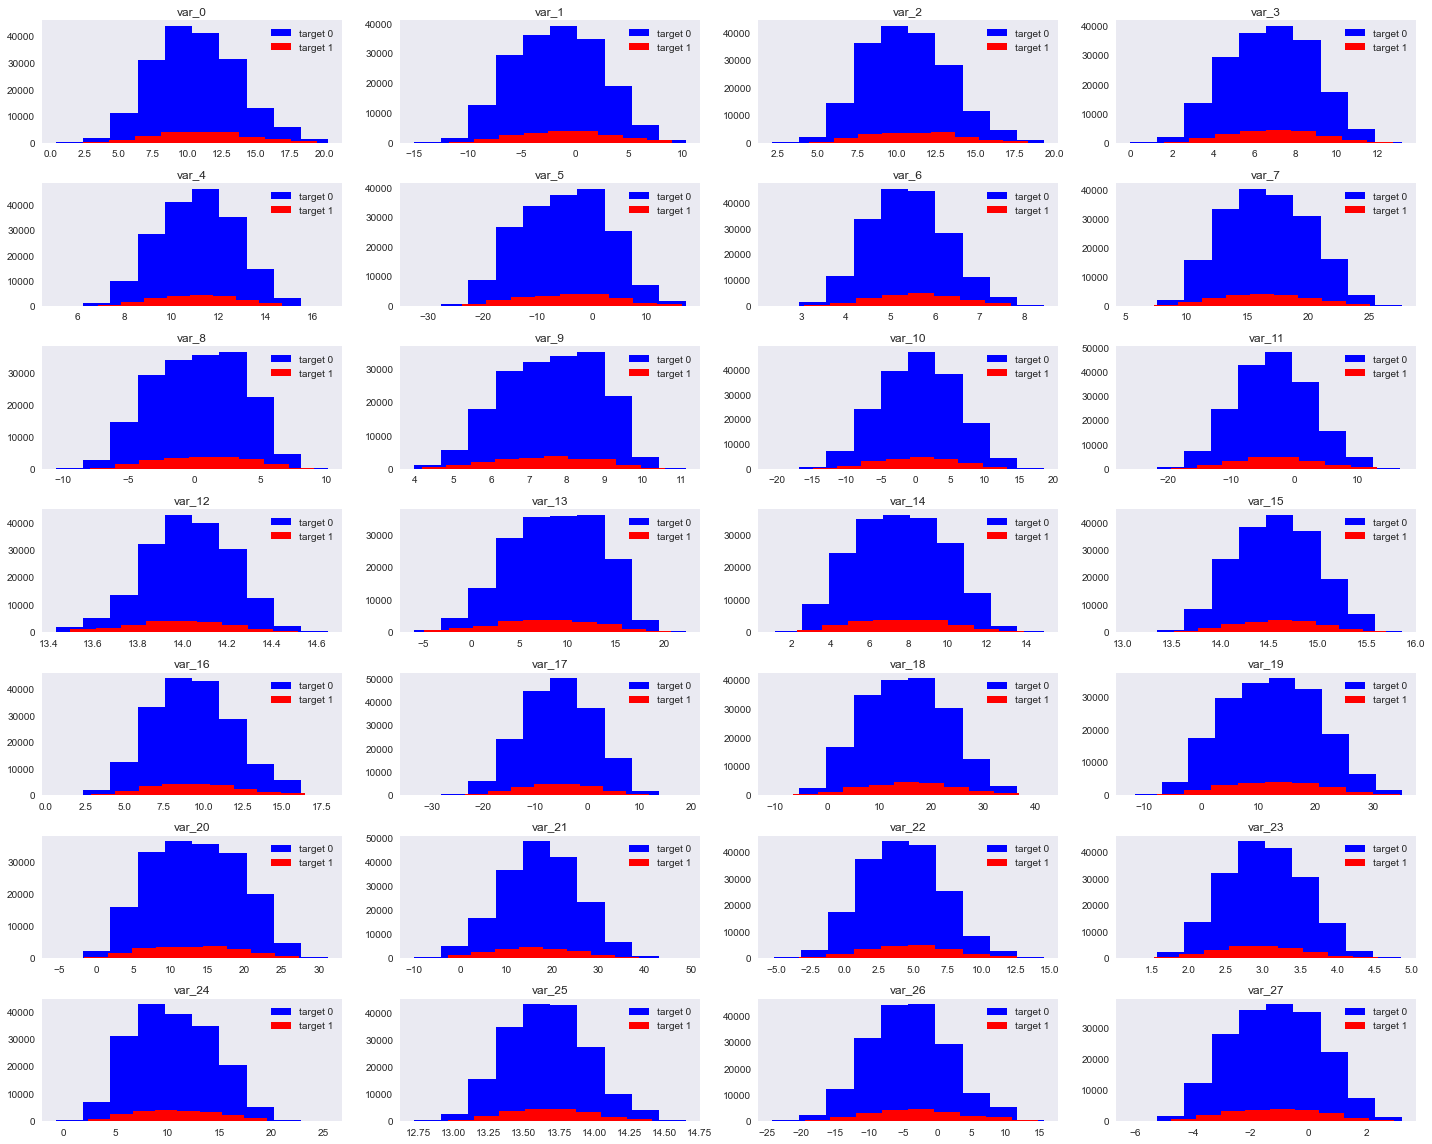

In [11]:
print('Distributions of 1st 100 features')
plt.figure(figsize=(20,16))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7,4,i + 1)
    plt.hist(t0[col],label='target 0',color='blue')
    plt.hist(t1[col],label='target 1',color='red')
    plt.title(col)
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()

Insights:
We can see from the above that nearly 90% of the Target value is 0(we assume that 0 stands for Customer didnot do transaction) and only 10% is 1(we assume 1 stands for Customer did a Transaction).
This makes the data significantly imbalanced. Let's drop the target number.

In [12]:

train.drop(['ID_code'],axis=1,inplace=True)
target =train['target']
train.drop(['target'],axis=1,inplace=True)
train.head(10)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
6,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,-4.3781,7.9232,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097
7,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,7.1971,...,13.1700,6.5491,3.9906,5.8061,23.1407,-0.3776,4.2178,9.4237,8.6624,3.4806
8,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,-3.1882,9.0827,...,1.4298,14.7510,1.6395,1.4181,14.8370,-1.9940,-1.0733,8.1975,19.5114,4.8453
9,12.5088,1.9743,8.8960,5.4508,13.6043,-16.2859,6.0637,16.8410,0.1287,7.9682,...,0.5543,6.3160,1.0371,3.6885,14.8344,0.4467,14.1287,7.9133,16.2375,14.2514


# Performing EDA

In [13]:
#Mean of the train values
features = train.columns.tolist()

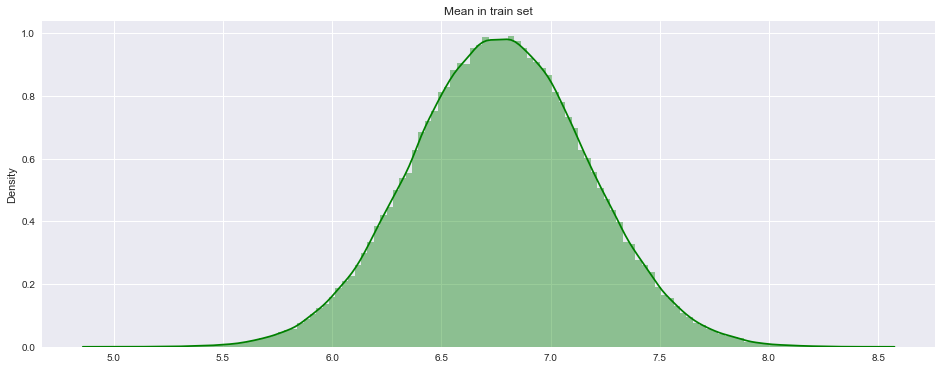

In [14]:
plt.figure(figsize=(16,6))
plt.title("Mean in train set")
sns.distplot(train[features].mean(axis=1), color="green", kde=True, bins=120)
plt.show()

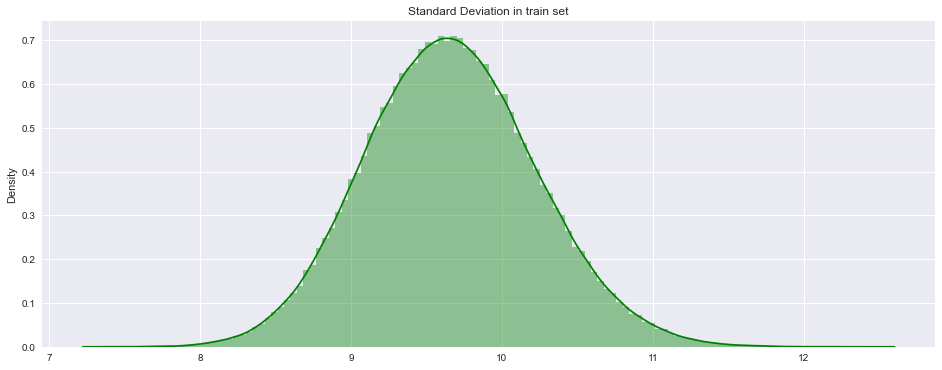

In [15]:
#standard deviation
plt.figure(figsize=(16,6))
plt.title("Standard Deviation in train set")
sns.distplot(train[features].std(axis=1), color="green", kde=True, bins=120)
plt.show()

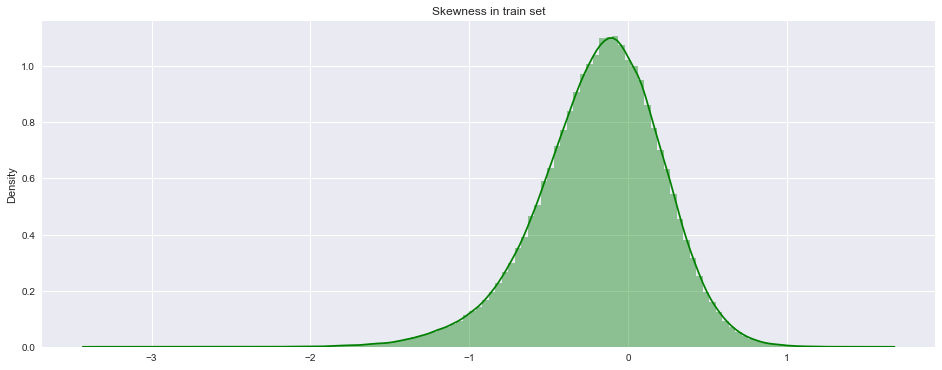

In [16]:
#Skewness
plt.figure(figsize=(16,6))
plt.title("Skewness in train set")
sns.distplot(train[features].skew(axis=1), color="green", kde=True, bins=120)
plt.show()

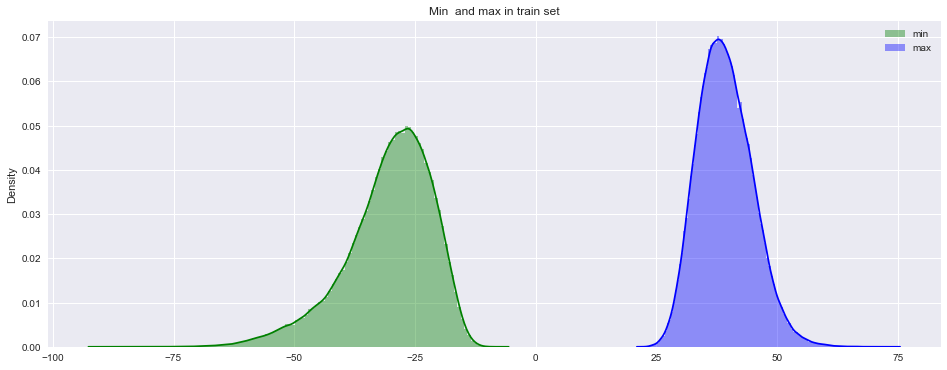

In [17]:
#Min and Max in train test
plt.figure(figsize=(16,6))
plt.title("Min  and max in train set")
sns.distplot(train[features].min(axis=1), color="green", kde=True, bins=120, label='min')
sns.distplot(train[features].max(axis=1), color="blue", kde=True, bins=120, label='max')
plt.legend()
plt.show()


#### Duplicate values

In [18]:
features = train.columns.values[2:202]
unique_max_train = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

In [19]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

,66,106,124,10,89,101,146,69,159,23,123,167,41,164,131
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_169,var_43,var_166,var_133
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,5.6941,11.4522,2.7306,6.8632


In [20]:
idx = features = train.columns.values[2:202]
for df in [train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [21]:
train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,12.7803,-1.0914,1454.1790,-21.4494,43.1127,7.344338,9.324130,0.100055,1.360265,6.77040
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,18.3560,1.9518,1408.0103,-47.3797,40.5632,7.111163,10.352786,-0.357548,4.135555,7.22315
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,14.7222,0.3965,1235.0330,-22.4038,33.8820,6.237540,8.772832,-0.063240,0.546658,5.89940
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,17.9697,-8.9996,1279.3233,-35.1659,38.1015,6.461229,9.617536,-0.484732,2.634111,6.70260
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,17.9974,-8.8104,1345.8775,-65.4863,41.1037,6.797361,11.326881,-1.468049,9.752397,6.94735


Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target

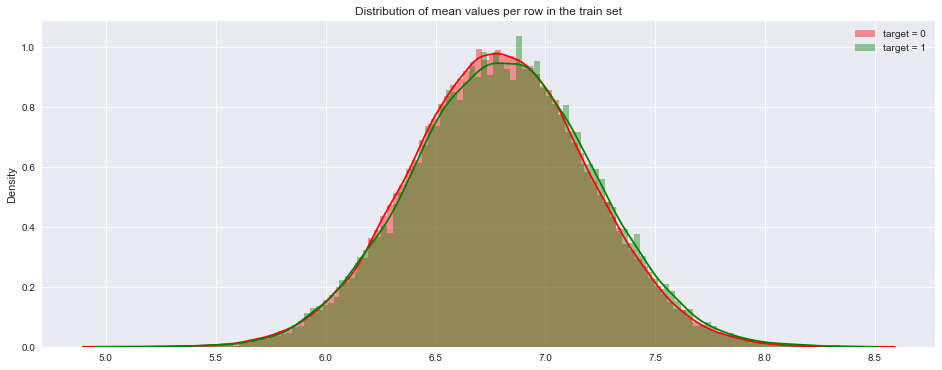

In [22]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the mean values per columns in the train and test datasets.

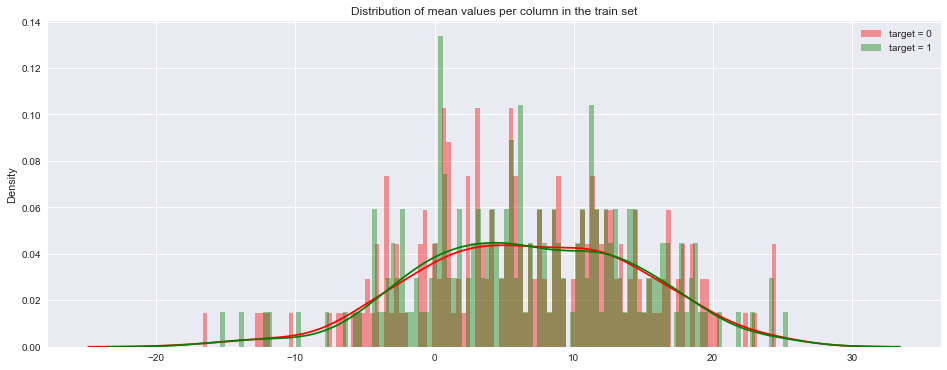

In [23]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of the standard deviation  per row in the train dataset, grouped by value of target

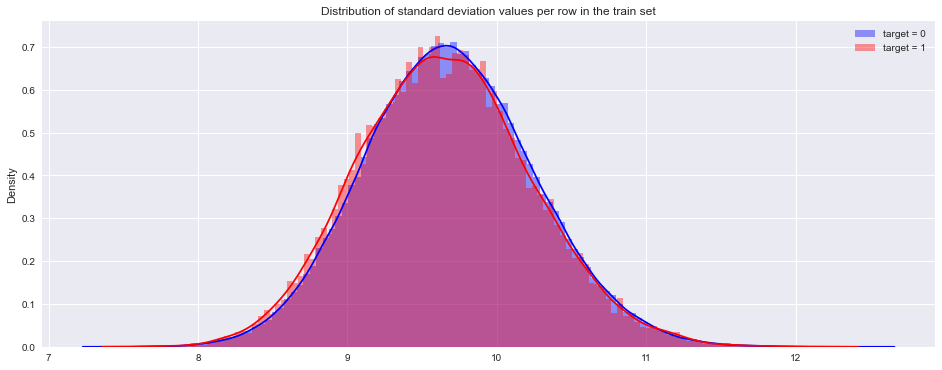

In [24]:

t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per row in the train set")
sns.distplot(t0[features].std(axis=1),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=1),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's check now the distribution of standard deviation per columns in the train and test datasets.

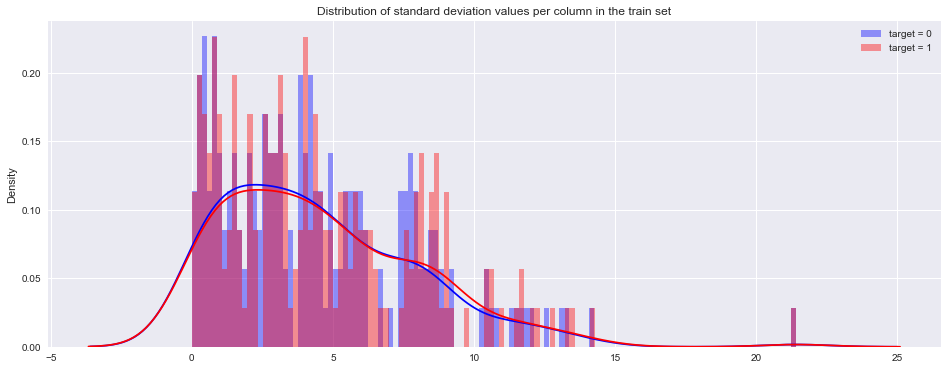

In [25]:

t0 = train.loc[target  == 0]
t1 = train.loc[target  == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per column in the train set")
sns.distplot(t0[features].std(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=0),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of skewness on rows in train separated for values of target 0 and 1. We found the distribution is left skewed

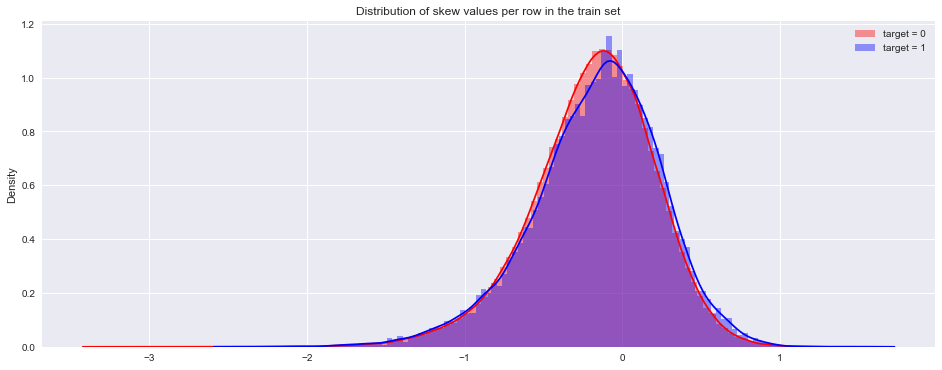

In [26]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of skewness on columns in train separated for values of target 0 and 1.

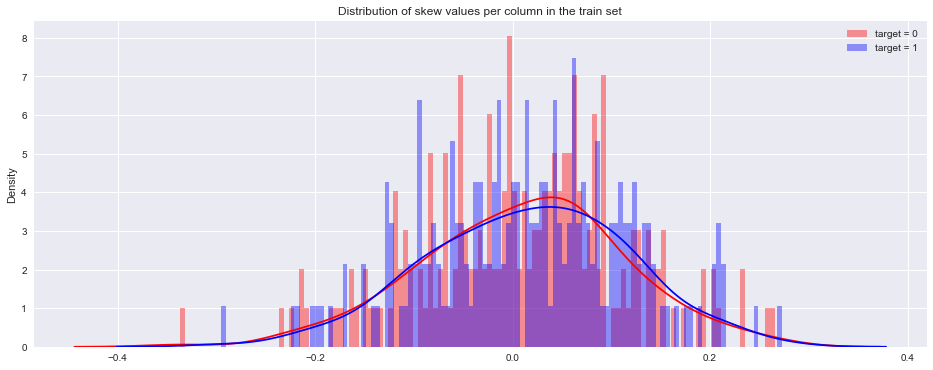

In [27]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

Let's see now the distribution of kurtosis on rows in train separated for values of target 0 and 1. We found the distribution to be Leptokurtic

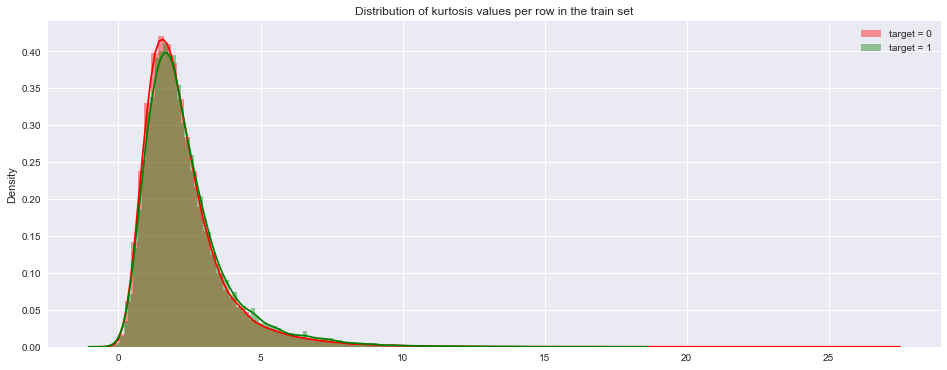

In [28]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

We use TSNE(t-distributed stochastic neighbor embedding) for better visualization of the data and getting to know the spread of the target data in our data set.

Let's see now the distribution of kurtosis on columns in train separated for values of target 0 and 1.

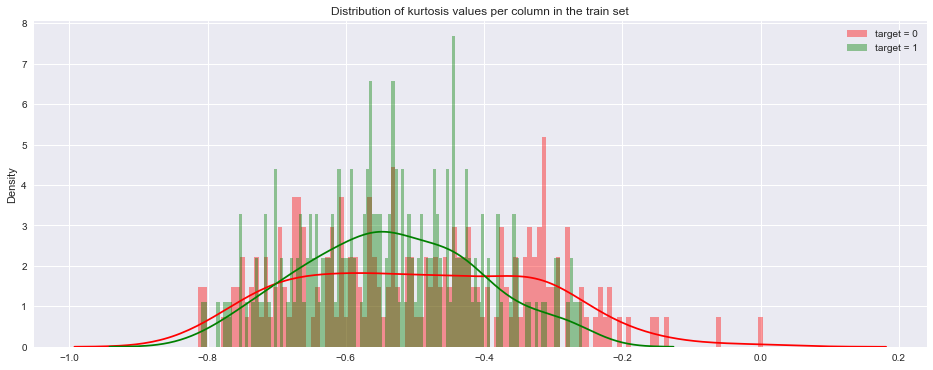

In [29]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train)

Principal Component Analysis to check Dimentionality Reduction

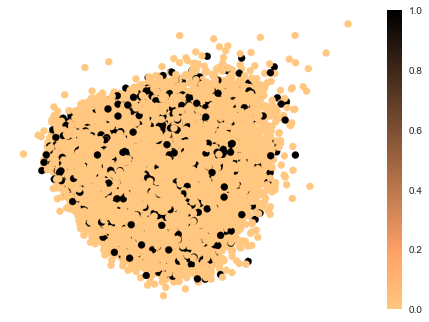

In [31]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

As we can see from above the data cannot be separate.The points are massively overlapped. 

Kernel PCA (Since the Graph above doesn't represent meaningful analysis)

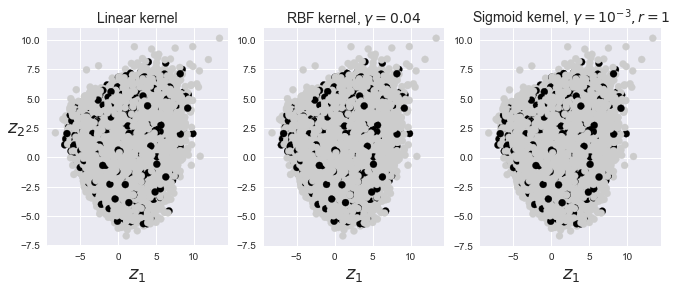

In [32]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

Since PCA hasn't been useful, I decided to proceed with the existing dataset

# LiGHT GBM

In [33]:
import lightgbm as lgb

In [34]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [35]:
num_folds = 11
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import roc_auc_score, roc_curve
folds = StratifiedKFold(n_splits= num_folds,random_state=44000)
oof = np.zeros(len(train))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
  
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round,valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
   
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


Fold 0
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.920199	valid_1's auc: 0.890552
[10000]	training's auc: 0.939	valid_1's auc: 0.89585
[15000]	training's auc: 0.952422	valid_1's auc: 0.89646
Early stopping, best iteration is:
[14007]	training's auc: 0.949923	valid_1's auc: 0.896551
Fold 1
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.920102	valid_1's auc: 0.890015
[10000]	training's auc: 0.938851	valid_1's auc: 0.895678
[15000]	training's auc: 0.952386	valid_1's auc: 0.896028
Early stopping, best iteration is:
[15815]	training's auc: 0.954316	valid_1's auc: 0.896132
Fold 2
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.92066	valid_1's auc: 0.88504
[10000]	training's auc: 0.93938	valid_1's auc: 0.889442
[15000]	training's auc: 0.952676	valid_1's auc: 0.890411
Early stopping, best iteration is:
[15739]	training's auc: 0.954434	valid_1's auc: 0.890479
Fold 3
Train